This notebook follows a NIRCam example. See the file 20240416a_solve_for_nircam_weights.ipynb for more information.

In [28]:
# Standard packages
using Revise, Glob, FITSIO, HDF5, Plots, FFTW, Statistics, RomanST, CUDA

# Load SIRS
using SIRS

# Definitions. I am working on the National Center for Climate Simulation (NCCS)
# high performance Prism cluster.
prog_id = "01497"                         # The input data are from this Program ID
datdir = "/lscratch/brausche/IRS"         # Stage data to Prism's high speed disks
outdir = "/explore/nobackup/people/brausche"*
                "/data/JWST/Library/SIRS" # Write results here
nint = 2                                  # Number of integrations per exposure
nframe = 120                              # This many frames per integration
nz = 30                                   # Work in "chunks" of this many frames to fit in GPU RAM

# The flight data have many cosmic rays. Instantiate the
# cosmic ray fixer.
F = CRFix(nframe);

[ Info: Precompiling RomanST [086cc5bb-2461-57d8-8068-0aed7f5b5cd1]


In [19]:
# Get input files
files = glob("*_nis_*.fits", datdir);

In [20]:
# Do it
f, γ, ζ, ps_𝓵, ps_𝓻, ps_𝓷 = nircam_sirs_solve(F, nz, [files[4],])

# Save
SIRS.h5write(prog_id, Float32.(f), [γ,], [ζ,], [ps_𝓵,], [ps_𝓻,], [ps_𝓷,],
                ["nis",], outdir*"/20240430_sirs_niriss.h5")

processing jw01497004001_02201_00001_nis_refpixstep.fits integration 1
processing jw01497004001_02201_00001_nis_refpixstep.fits integration 2
processing jw01497004001_02201_00001_nis_refpixstep.fits integration 3
processing jw01497004001_02201_00001_nis_refpixstep.fits integration 4
processing jw01497004001_02201_00001_nis_refpixstep.fits integration 5


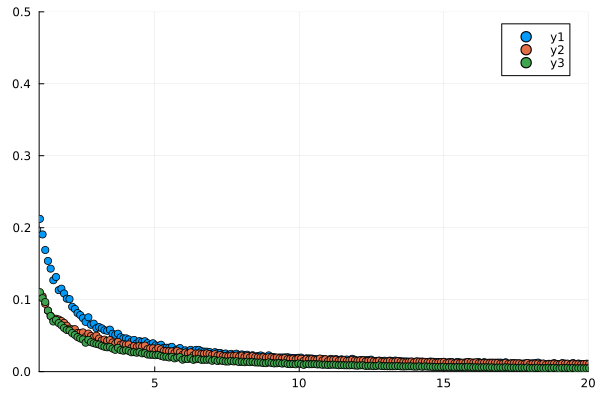

In [21]:
x = rfftfreq(2048, 1/(524*10.e-6)) # Frequency
scatter(x[2:end], ps_𝓵[2:end])
scatter!(x[2:end], ps_𝓻[2:end])
scatter!(x[2:end], mean(ps_𝓷[2:end,:], dims=2))
scatter!(xlim=[1,20], ylim=(0,.5))

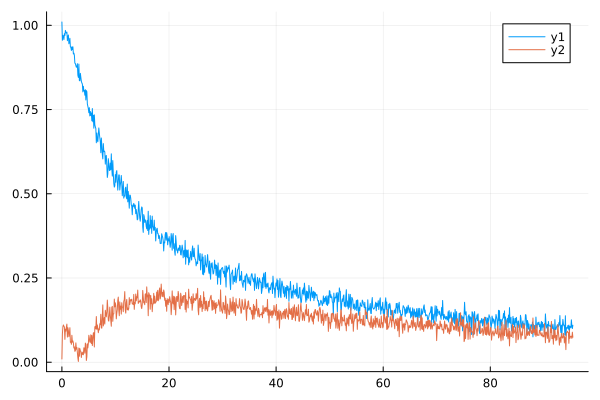

In [47]:
op = 1
plot(x[1:end],[abs.(γ[1:end,op]),abs.(ζ[1:end,op])])

Something is wrong in the left reference columns. Fit a slope image and examine.

In [34]:
# Get
D = FITS(files[4], "r") do fid
    CuArray(read(fid[2],:,:,1:55,1))
end

# Fit
Λ = Legendre(55,1)
S = 1.61*signal(Λ,D)

# Change coordinates
S = permutedims(S, (2,1))[end:-1:1,end:-1:1]

2048×2048 CuArray{Float64, 2, CUDA.Mem.DeviceBuffer}:
 -0.908231     2.19038     -8.26186   …   -8.72823    -4.19212     1.50038
  5.76868     -7.21991      4.03731       -3.2588      5.78786    -0.390194
  2.88046      8.3365       5.24427       -7.84018    -0.761293  -11.3285
 -0.11524     10.6115      -1.37408       -6.55547    -3.49521     1.62232
 -5.92991     -0.544065    -7.92962       -5.80212    -4.18573     1.40453
  3.71144      0.0698172    7.73648   …    1.97371    -5.58436   -11.6666
  3.60878      0.5612     -14.2227        -7.11186    -9.22657    -3.88543
 -4.93908      3.51981     -3.00964      -14.1135      1.12398     3.8648
 -7.12466      2.76538     -3.44462       -9.96128    -9.11158    -4.72242
 -1.16958      1.64787      0.363712     -12.5227     -2.93935    10.0173
  5.98552      5.70428     -2.3074    …  -16.1266     -1.30435    -5.91712
 -3.16297     -0.102686    -0.109079     -10.9382      5.33426    -9.37298
 -0.927417     8.39399     -6.19183       -8.5365

In [35]:
FITS("/home/brausche/tmp/S.fits", "w") do fid
    write(fid, Array(S))
end

In [45]:
l = S[1:4,:]
r = S[2045:2048,:]

1.4826median(abs.(l .- median(l)))

6.786406133269251

In [46]:
1.4826median(abs.(r .- median(r)))

6.4141249827622175